In [425]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [426]:
with open('fra.txt',encoding='utf-8',errors='ignore')as file:
    text=file.read().split('\n')

In [427]:
## Creating and input and target list and using only 10,000

input_texts = []
target_texts =[]

Num_samples = 10000
for line in text[:Num_samples]:
    english,french = line.split("\t")[:2]
    input_texts.append(english.lower())
    target_texts.append(french.lower())
input_texts[:5],target_texts[:5]
    

(['go.', 'go.', 'go.', 'go.', 'hi.'],
 ['va !', 'marche.', 'en route !', 'bouge !', 'salut !'])

## Data Preprocessing

In [428]:
import re
for ix,i in enumerate(input_texts):
    input_texts[ix]= re.sub("[!#$%&'()*+,-./:;<=>?@[\]^_`{|}~]","",i)  
for ix,i in enumerate(target_texts):
    target_texts[ix]= re.sub("[!#$%&'()*+,-./:;<=>?@[\]^_`{|}~]","",i) 

In [429]:
input_texts[:5],target_texts[:5]

(['go', 'go', 'go', 'go', 'hi'],
 ['va ', 'marche', 'en route ', 'bouge ', 'salut '])

### Adding Start/End Tags

In [430]:
target_texts = ['<start> '+s+' <end>' for s in target_texts]

In [431]:
target_texts[0]

'<start> va  <end>'

In [432]:
from tensorflow.keras.preprocessing.text import Tokenizer

## Converting inputs words to index

tokenizer_in = Tokenizer()
tokenizer_in.fit_on_texts(input_texts)
input_token = tokenizer_in.word_index
input_vocab_size = len(tokenizer_in.word_index)+1
print(input_vocab_size)

2006


In [433]:
## Converting output words to index

tokenizer_out =Tokenizer(filters='')
tokenizer_out.fit_on_texts(target_texts)
output_token=tokenizer_out.word_index
output_vocab_size=len(tokenizer_out.word_index)+1
output_vocab_size

4711

In [434]:
tokenized_input=tokenizer_in.texts_to_sequences(input_texts)
#max length of the input
maxlen_input = max( [ len(x) for x in tokenized_input ] )
padded_input = pad_sequences( tokenized_input , maxlen=maxlen_input ,padding='post' )
encoder_input_data = np.array( padded_input )

In [435]:
#converting tokenized output sentence into sequences
tokenized_output = tokenizer_out.texts_to_sequences(target_texts)


# teacher forcing
for i in range(len(tokenized_output)):
    tokenized_output[i] = tokenized_output[i][1:]
maxlen_output = max([len(x) for x in tokenized_output])
padding_output= pad_sequences(tokenized_output,maxlen=maxlen_output,padding='post')
decoder_input_data = np.array(padding_output)

In [436]:
decoder_input_data.shape,encoder_input_data.shape

((10000, 11), (10000, 4))

In [437]:
# decode target output
decoder_target_one_hot = tf.keras.utils.to_categorical(padding_output,num_classes=output_vocab_size)

In [438]:
#creating dictionary of words corresponding to vectors
print('Indexing word vectors.')
embeddings_index = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [439]:
#embedding matrix
num_words = len(tokenizer_in.word_index)+1
word2idx_input = tokenizer_in.word_index
embedding_matrix = np.zeros((num_words, 200))
for word,i in word2idx_input.items():
    if i<num_words:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(2006, 200)

## Defining Embedding Layer AND ENCODERS

In [440]:
#lstm hidden dimesions
LATENT_DIM = 256
#embedding layer dimensions
EMBEDDING_DIM = 200
embedding_layer = tf.keras.layers.Embedding(input_vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=maxlen_input)

In [441]:
# encoder 
encoderrr_inputs = tf.keras.layers.Input(shape=(maxlen_input),name = 'encoderinputs')

In [442]:
encoder_input = embedding_layer(encoderrr_inputs)
encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LATENT_DIM,return_sequences=True,dropout = 0.3),name = 'encoder_bidirection')


In [443]:
encoder_outputs = encoder(encoder_input)

In [444]:
encoder_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'encoderinputs')>

## Defining Decoder

In [445]:
LATENT_DIM =256
EMBEDDING_DIM = 200
decoderrr_inputs = tf.keras.layers.Input(shape=(maxlen_output),name='decoderinputs')
embedding_layer_out = tf.keras.layers.Embedding(output_vocab_size,EMBEDDING_DIM,name="decoder_embedding")
decoder_input = embedding_layer_out(decoderrr_inputs)

In [446]:
decoderrr_inputs.shape

TensorShape([None, 11])

In [447]:
output_vocab_size

4711

## Defining Decoder Layers

In [448]:
decoder_lstm = tf.keras.layers.LSTM(LATENT_DIM,return_state=True,name='decoder_lstm')

decoder_dense = tf.keras.layers.Dense(output_vocab_size,activation='softmax',name='decoder_dense')

## Attention Network

In [449]:
# Computing alphas
import tensorflow.keras.backend as k
def softmax_attention(x):
    assert(k.ndim(x)>2)
    e=k.exp(x-k.max(x,axis=1,keepdims=True))
    s=k.sum(e,axis=1,keepdims=True)
    return e/s

In [450]:
attention_repeat = tf.keras.layers.RepeatVector(maxlen_input)
attention_concat = tf.keras.layers.Concatenate(axis=-1)
dense1_layer = tf.keras.layers.Dense(10,activation='tanh')
dense2_layer = tf.keras.layers.Dense(1,activation = softmax_attention)
dot_layer = tf.keras.layers.Dot(axes=1)
def context_attention(h, st_1):
    st_1=attention_repeat(st_1)
    x=attention_concat([h,st_1])
    x=dense1_layer(x)
    alphas=dense2_layer(x)
    context = dot_layer([alphas,h])
    return context

initial_s = tf.keras.layers.Input(shape=(LATENT_DIM,), name='s0')
initial_c = tf.keras.layers.Input(shape=(LATENT_DIM,), name='c0')
context_last_word_concat_layer = tf.keras.layers.Concatenate(axis=2)


s = initial_s
c = initial_c
outputs = []
#collect output in a list at first
for t in range(maxlen_output): #ty times
    #get the context using attention mechanism
    context=context_attention(encoder_outputs,s)
     #we need a different layer for each time step
    selector=tf.keras.layers.Lambda(lambda x: x[:,t:t+1])
    x_t=selector(decoder_input)
    #combine
    decoder_lstm_input=context_last_word_concat_layer([context,x_t])
    #pass the combined [context,last word] into lstm
    #along with [s,c]
    #get the new[s,c] and output
    out,s,c=decoder_lstm(decoder_lstm_input,initial_state=[s,c])
    #final dense layer to get next word prediction
    decoder_outputs = decoder_dense(out)
    outputs.append(decoder_outputs)



In [451]:
outputs

[<KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4711) dtype=float32 (created by layer 'decoder_dense')>]

In [452]:
def stack(x):
    x=k.stack(x)
    x=k.permute_dimensions(x,pattern=(1,0,2))
    return x
stacker=tf.keras.layers.Lambda(stack)
outputs=stacker(outputs)
outputs


<KerasTensor: shape=(None, 11, 4711) dtype=float32 (created by layer 'lambda_100')>

### Defining Model
Our final model will have an encoder, a decoder, and our initial states for the encoder as inputs, and the outputs would be our final outputs as generated earlier. The model is defined using the following statement:

In [453]:
encoder_inputs,decoder_inputs

(<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'encoderinputs')>,
 <KerasTensor: shape=(None, 11) dtype=float32 (created by layer 'decoder_input')>)

In [454]:
model1=tf.keras.models.Model(inputs=[encoderrr_inputs,decoderrr_inputs,initial_s,initial_c],outputs=outputs)

In [455]:
model1.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoderinputs (InputLayer)     [(None, 4)]          0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 4, 200)       401200      ['encoderinputs[0][0]']          
                                                                                                  
 s0 (InputLayer)                [(None, 256)]        0           []                               
                                                                                                  
 encoder_bidirection (Bidirecti  (None, 4, 512)      935936      ['embedding_7[0][0]']            
 onal)                                                                                     

                                                                  'dense_27[4][0]',               
                                                                  'encoder_bidirection[0][0]',    
                                                                  'dense_27[5][0]',               
                                                                  'encoder_bidirection[0][0]',    
                                                                  'dense_27[6][0]',               
                                                                  'encoder_bidirection[0][0]',    
                                                                  'dense_27[7][0]',               
                                                                  'encoder_bidirection[0][0]',    
                                                                  'dense_27[8][0]',               
                                                                  'encoder_bidirection[0][0]',    
          

                                                                                                  
 lambda_94 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_95 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_96 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_97 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_98 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
          

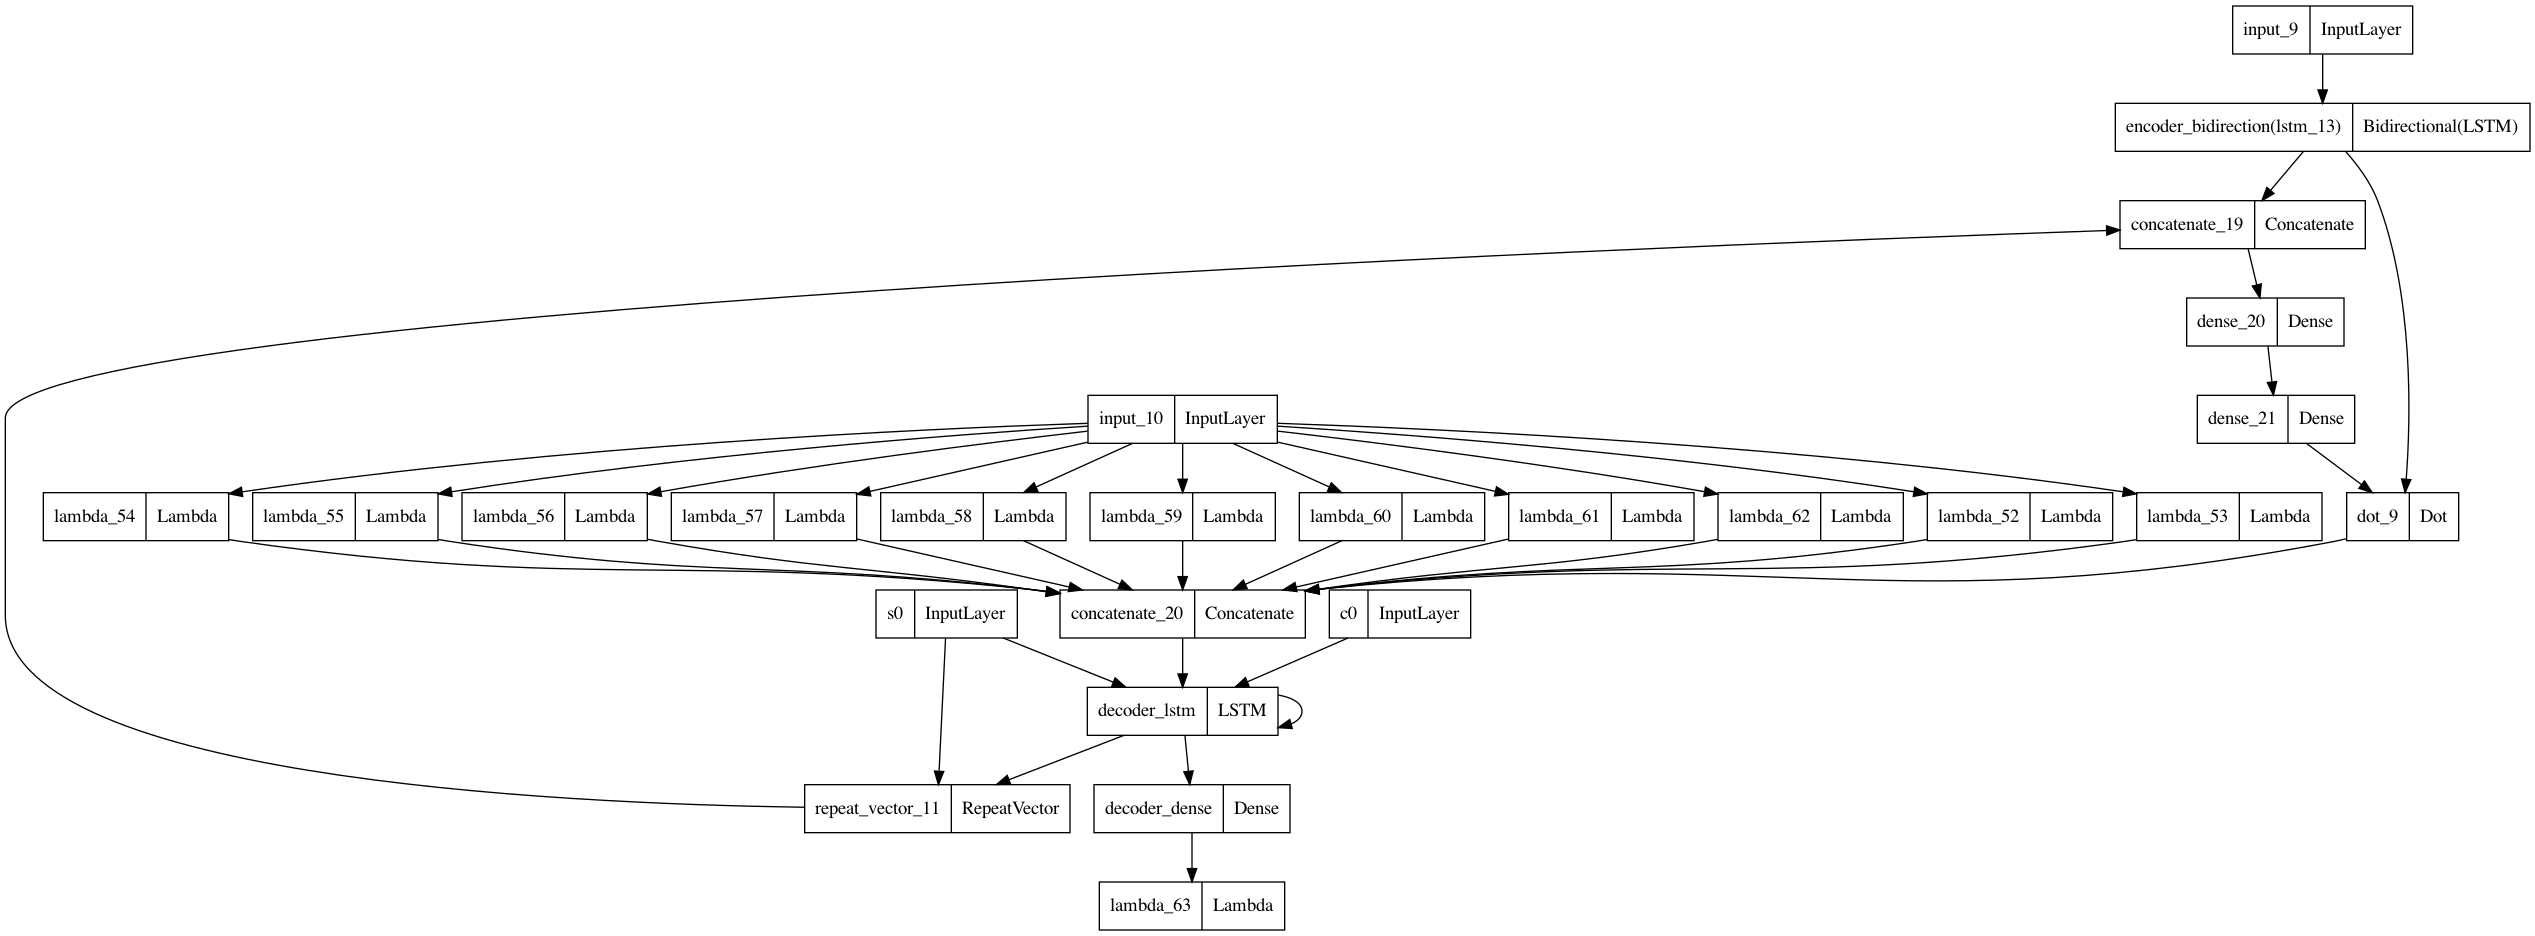

In [355]:
tf.keras.utils.plot_model(model1)

In [356]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


### Model Training
We create the initial states by taking zero as inputs.

In [357]:
initial_s_training=np.zeros((Num_samples,LATENT_DIM))
initial_c_training =np.zeros(shape=(Num_samples,LATENT_DIM))

In [360]:

R = model1.fit([np.expand_dims(encoder_input_data,axis=-1),np.expand_dims(decoder_input_data,axis=-1),initial_s_training,initial_c_training],decoder_target_one_hot,batch_size=100,epochs=100,validation_split=0.3)



Epoch 1/100


ValueError: in user code:

    File "/Users/ngounepeetprogress/opt/anaconda3/envs/deepL/lib/python3.7/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/ngounepeetprogress/opt/anaconda3/envs/deepL/lib/python3.7/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ngounepeetprogress/opt/anaconda3/envs/deepL/lib/python3.7/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/ngounepeetprogress/opt/anaconda3/envs/deepL/lib/python3.7/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/ngounepeetprogress/opt/anaconda3/envs/deepL/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/ngounepeetprogress/opt/anaconda3/envs/deepL/lib/python3.7/site-packages/keras/engine/input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "encoder_bidirection" "                 f"(type Bidirectional).
    
    Input 0 of layer "forward_lstm_13" is incompatible with the layer: expected shape=(None, None, 200), found shape=(100, 4, 1)
    
    Call arguments received by layer "encoder_bidirection" "                 f"(type Bidirectional):
      • inputs=tf.Tensor(shape=(100, 4, 1), dtype=float32)
      • training=True
      • mask=None
      • initial_state=None
      • constants=None


In [424]:
initial_s_training.shape,initial_c_training.shape

((10000, 256), (10000, 256))

In [256]:
decoder_input_data.shape

(10000, 11)

In [ ]:
### test new ######

In [457]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, LSTM, Embedding, Bidirectional,RepeatVector, Concatenate, Activation,Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import preprocessing, utils
import numpy as np
import matplotlib.pyplot as plt
!pip install wget
import wget
# reading data
with open('fra.txt',encoding='utf-8',errors='ignore')as file:
    text=file.read().split('\n')
len(text)

217976

In [458]:
#max length of the input
maxlen_input = max( [ len(x)
                    for x in tokenized_input ] )
#padding sequence to the maximum length
padded_input = pad_sequences( tokenized_input , maxlen=maxlen_input ,padding='post' )
padded_input[2000:2010]
encoder_input_data = np.array( padded_input )
print( encoder_input_data.shape)
#converting tokenized text into sequences
tokenized_output = tokenizer_out.texts_to_sequences(target_texts)
output_vocab_size=len(tokenizer_out.word_index) + 1
output_vocab_size
# teacher forcing
for i in range(len(tokenized_output)) :
    tokenized_output[i] = tokenized_output[i][1:]
# padding
maxlen_output = max( [ len(x) for x in tokenized_output ] )
padded_output = pad_sequences( tokenized_output ,maxlen=maxlen_output ,padding='post' )
# converting to numpy
decoder_input_data = np.array( padded_output )
decoder_input_data[2000:2010]

(10000, 4)


array([[   3,   18,    5,  174,    2,    0,    0,    0,    0,    0,    0],
       [   3,   18,    5,  104,    2,    0,    0,    0,    0,    0,    0],
       [  51,   42,  266,  202,    2,    0,    0,    0,    0,    0,    0],
       [   3,    5,  339,  118,    2,    0,    0,    0,    0,    0,    0],
       [   3,    5, 1546,  118,    2,    0,    0,    0,    0,    0,    0],
       [   3,   15,  820,    2,    0,    0,    0,    0,    0,    0,    0],
       [1547,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  13, 2636,   11,  235,    2,    0,    0,    0,    0,    0,    0],
       [   3,   43,  129,    2,    0,    0,    0,    0,    0,    0,    0],
       [   3,   43,  821,    2,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [459]:
#decoder target output
decoder_target_one_hot=np.zeros((len(input_texts),maxlen_output,output_vocab_size),dtype='float32')
for i,d in enumerate(padded_output):
    for t,word in enumerate(d):
        decoder_target_one_hot[i,t,word]=1
decoder_target_one_hot[0]
#creating dictionary of words corresponding to vectors
print('Indexing word vectors.')
embeddings_index = {}
# Use this open command in case of downloading using wget above
#f = open('glove.6B.200d.txt', encoding='utf-8')
# we can choose any dimensions 50 100 200 300
f = open('glove.6B.200d.txt',
                encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Indexing word vectors.


In [460]:
print('Found %s word vectors.' %
            len(embeddings_index))
embeddings_index["any"]
#embedding matrix
num_words = len(tokenizer_in.word_index)+1
word2idx_input = tokenizer_in.word_index
embedding_matrix = np.zeros((num_words, 200))
for word,i in word2idx_input.items():
    if i<num_words:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape
#lstm hidden dimensions
LATENT_DIM=256
#embeding layer dimensions
EMBEDDING_DIM=200
embedding_layer=Embedding(input_vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=maxlen_input)
#encoder
encoder_inputs = Input(shape=(maxlen_input,),name = 'encoderinput')
encoder_input = embedding_layer(encoder_inputs)
encoder = Bidirectional(LSTM(LATENT_DIM,return_sequences=True,dropout = 0.3),name = 'encoder_bidirection')

Found 400000 word vectors.


In [461]:
encoder_inputs.shape

TensorShape([None, 4])

In [462]:
encoder_outputs = encoder(encoder_input)
encoder_outputs.shape
decoder_inputs = Input(shape=(maxlen_output,),
                      name='decoder_input')
decoder_embedding = Embedding(output_vocab_size,
                            EMBEDDING_DIM,
                            name='decoder_embedding')
decoder_input=decoder_embedding(decoder_inputs)
decoder_input.shape
#decoder lstm
decoder_lstm = LSTM(LATENT_DIM,return_state = True,name = 'decoder_lstm')
#decoder dense with softmax for predicting each word
decoder_dense = Dense(output_vocab_size,activation='softmax',name='decoder_dense')
# Computing alphas
import tensorflow.keras.backend as k
def softmax_attention(x):
    assert(k.ndim(x)>2)
    e=k.exp(x-k.max(x,axis=1,keepdims=True))
    s=k.sum(e,axis=1,keepdims=True)
    return e/s
# nerual network layers for our repeated use
attention_repeat =  RepeatVector(maxlen_input)
attention_concat = Concatenate(axis=-1)
dense1_layer = Dense(10,activation='tanh')

In [463]:
dense2_layer = Dense(1,activation = softmax_attention)
dot_layer = Dot(axes=1)
# computing attention context
def context_attention(h, st_1):
    st_1=attention_repeat(st_1)
    x=attention_concat([h,st_1])
    x=dense1_layer(x)
    alphas=dense2_layer(x)
    context = dot_layer([alphas,h])
    return context
#initial states to be fed
initial_s = Input(shape=(LATENT_DIM,), name='s0')
initial_c = Input(shape=(LATENT_DIM,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)
s = initial_s
c = initial_c
outputs = []
#collect output in a list at first
for t in range(maxlen_output): #ty times
    #get the context using attention mechanism
    context=context_attention(encoder_outputs,s)
    #we need a different layer for each time step
    selector=Lambda(lambda x: x[:,t:t+1])
    x_t=selector(decoder_input)
    #combine
    decoder_lstm_input=context_last_word_concat_layer([context,x_t])
        #pass the combined [context,last word] into lstm
    #along with [s,c]
    #get the new[s,c] and output
    out,s,c=decoder_lstm(decoder_lstm_input,
                            initial_state=[s,c])
    #final dense layer to get next word prediction
    decoder_outputs = decoder_dense(out)
    outputs.append(decoder_outputs)

In [374]:
def stack(x):
    x=k.stack(x)
    x=k.permute_dimensions(x,pattern=(1,0,2))
    return x
stacker=Lambda(stack)
outputs=stacker(outputs)
outputs
model=Model(inputs=[encoder_inputs,decoder_inputs,initial_s,initial_c],outputs=outputs)
model.summary()
tf.keras.utils.plot_model (model)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
initial_s_training=np.zeros((Num_samples,LATENT_DIM))
#initial s c

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoderinput (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 4, 200)       401200      ['encoderinput[0][0]']           
                                                                                                  
 s0 (InputLayer)                [(None, 256)]        0           []                               
                                                                                                  
 encoder_bidirection (Bidirecti  (None, 4, 512)      935936      ['embedding_5[0][0]']            
 onal)                                                                                      

                                                                  'dense_25[4][0]',               
                                                                  'encoder_bidirection[1][0]',    
                                                                  'dense_25[5][0]',               
                                                                  'encoder_bidirection[1][0]',    
                                                                  'dense_25[6][0]',               
                                                                  'encoder_bidirection[1][0]',    
                                                                  'dense_25[7][0]',               
                                                                  'encoder_bidirection[1][0]',    
                                                                  'dense_25[8][0]',               
                                                                  'encoder_bidirection[1][0]',    
          

                                                                                                  
 lambda_80 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_81 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_82 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_83 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
                                                                                                  
 lambda_84 (Lambda)             (None, 1, 200)       0           ['decoder_embedding[0][0]']      
          

In [376]:
initial_c_training =np.zeros(shape=(Num_samples,LATENT_DIM))
r = model.fit([encoder_input_data,
               decoder_input_data,
               initial_s_training,
               initial_c_training],
               decoder_target_one_hot,
               batch_size=100,
               epochs=100,
               validation_split=0.3)


Epoch 1/100
70/70 [==============================] - 68s 693ms/step - loss: 3.0677 - accuracy: 0.6425 - val_loss: 2.5495 - val_accuracy: 0.6001
Epoch 2/100
70/70 [==============================] - 24s 339ms/step - loss: 2.0117 - accuracy: 0.6856 - val_loss: 2.4157 - val_accuracy: 0.6468
Epoch 3/100
70/70 [==============================] - 28s 402ms/step - loss: 1.9098 - accuracy: 0.7071 - val_loss: 2.3656 - val_accuracy: 0.6567
Epoch 4/100
70/70 [==============================] - 33s 472ms/step - loss: 1.8430 - accuracy: 0.7156 - val_loss: 2.3442 - val_accuracy: 0.6518
Epoch 5/100
70/70 [==============================] - 41s 584ms/step - loss: 1.7916 - accuracy: 0.7219 - val_loss: 2.2961 - val_accuracy: 0.6612
Epoch 6/100
70/70 [==============================] - 49s 699ms/step - loss: 1.7380 - accuracy: 0.7251 - val_loss: 2.2645 - val_accuracy: 0.6639
Epoch 7/100
70/70 [==============================] - 47s 668ms/step - loss: 1.6924 - accuracy: 0.7300 - val_loss: 2.2412 - val_accuracy:

70/70 [==============================] - 43s 618ms/step - loss: 0.4294 - accuracy: 0.8689 - val_loss: 1.9127 - val_accuracy: 0.7465
Epoch 58/100
70/70 [==============================] - 37s 527ms/step - loss: 0.4203 - accuracy: 0.8699 - val_loss: 1.9157 - val_accuracy: 0.7437
Epoch 59/100
70/70 [==============================] - 36s 518ms/step - loss: 0.4105 - accuracy: 0.8707 - val_loss: 1.9105 - val_accuracy: 0.7436
Epoch 60/100
70/70 [==============================] - 35s 498ms/step - loss: 0.4009 - accuracy: 0.8724 - val_loss: 1.9205 - val_accuracy: 0.7451
Epoch 61/100
70/70 [==============================] - 35s 499ms/step - loss: 0.3900 - accuracy: 0.8737 - val_loss: 1.9239 - val_accuracy: 0.7449
Epoch 62/100
70/70 [==============================] - 34s 491ms/step - loss: 0.3882 - accuracy: 0.8735 - val_loss: 1.9228 - val_accuracy: 0.7422
Epoch 63/100
70/70 [==============================] - 35s 495ms/step - loss: 0.3769 - accuracy: 0.8755 - val_loss: 1.9285 - val_accuracy: 0.744

In [464]:
encoder_model = Model(encoder_inputs, encoder_outputs)

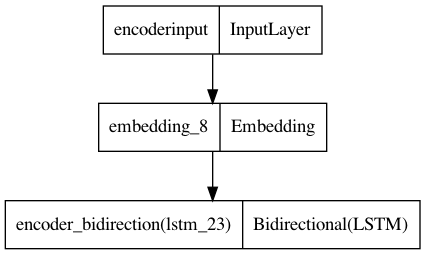

In [465]:
tf.keras.utils.plot_model (encoder_model)

In [466]:

encoder_outputs_as_input = Input(shape=(maxlen_input, LATENT_DIM* 2,))


In [467]:
decoder_input_embedding = Input(shape=(1,))

In [468]:
decoder_input_ = decoder_embedding(decoder_input_embedding)

In [469]:
context = context_attention(encoder_outputs_as_input, initial_s)


In [470]:
decoder_lstm_input = context_last_word_concat_layer([context, decoder_input_])

In [471]:
out, s, c = decoder_lstm(decoder_lstm_input,initial_state=[initial_s, initial_c])

In [472]:
decoder_outputs = decoder_dense(out)

In [473]:

decoder_model = Model(inputs=[decoder_input_embedding,encoder_outputs_as_input,initial_s,initial_c],outputs=[decoder_outputs, s, c])
decoder_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 s0 (InputLayer)                [(None, 256)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 4, 512)]     0           []                               
                                                                                                  
 repeat_vector_15 (RepeatVector  (None, 4, 256)      0           ['s0[0][0]']                     
 )                                                                                                
                                                                                                  
 concatenate_27 (Concatenate)   (None, 4, 768)       0           ['input_11[0][0]',        

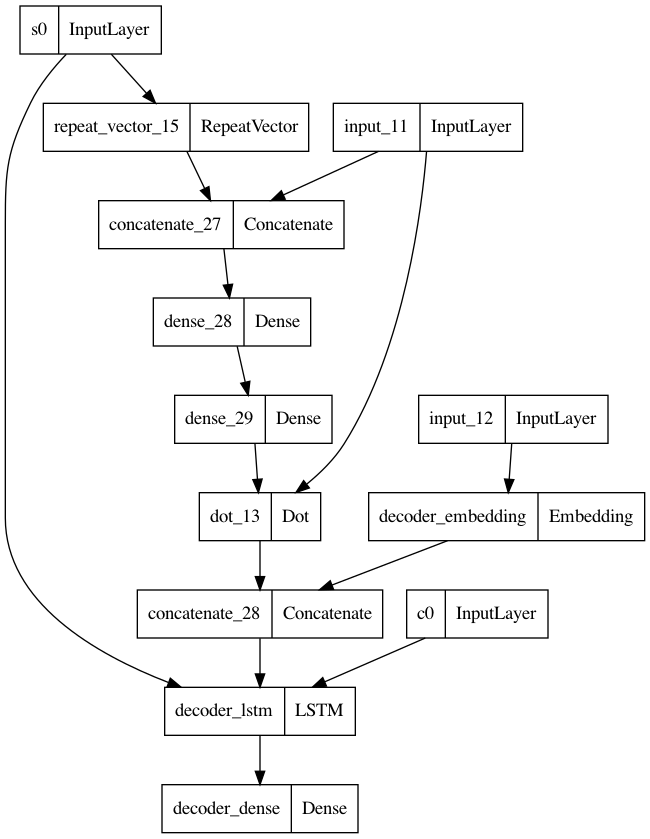

In [474]:
tf.keras.utils.plot_model (decoder_model)

## Translating
As the model processes the input text and predicts the output as integers, we need to create a reverse mapping from integers to index. We do this for both the languages using the following code:


In [475]:
word2index_input=tokenizer_in.word_index
word2index_output=tokenizer_out.word_index
#reverse mapping integer to words for english
idx2word_eng = {v:k for k, v in word2index_input.items()}
#reverse mapping integer to words for spanish
idx2word_trans = {v:k for k, v in word2index_output.items()}

In [483]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_out = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2index_output['<start>']
    # if we get this we break
    End_statement = word2index_output['<end>']
    # [s, c] will be updated in each loop iteration
    s = np.zeros((1,LATENT_DIM))
    c = np.zeros((1,LATENT_DIM))
    # Create the translation
    output_sentence = []
    for _ in range(maxlen_output):
        out, s, c = decoder_model.predict([target_seq,enc_out, s, c],verbose=0)
         # Get next word
        index = np.argmax(out.flatten())
        # End sentence
        if End_statement == index:
            break
        word = ''
        if index > 0:
            word = idx2word_trans[index]
            output_sentence.append(word)
            target_seq[0, 0] = index
    return ' '.join(output_sentence)
    # Update the decoder input
    # which is just the word just generated
    
  

In [ ]:
count=0
while (count<5):
    input_text=[str(input('input the sentence : '))]
    seq=tokenizer_in.texts_to_sequences(input_text)
    input_seq=pad_sequences(seq,maxlen=maxlen_input,padding='post')
    translation=decode_sequence(input_seq)
    print('Predicted translation:', translation)
    count+=1

input the sentence : what is your name
1/1 [==============================] - 0s 25ms/step
Predicted translation: là  pois tirerons ménerves tirerons tirerons tirerons l’aide l’aide l’aide l’aide
input the sentence : yyy
1/1 [==============================] - 0s 25ms/step
Predicted translation: jouets jeus jouets jeus passons passons dommage  distrait enterrele enterrele creusé
